In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from scipy.stats import beta
#from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats
from scipy.stats import gaussian_kde
import math
from datetime import datetime, timedelta

In [2]:
# Change directory to get data files:
path = ''
os.chdir(path)

# TODO: change directory for files export

OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: ''

Number of EVs to simulate

In [3]:

N_ev = 2000
n_households = 126

# 1. User data Table Simulation

### 1.1.	User ID:

Pick user number randomly without replacement

In [4]:
# Series of N Users as numebr of EVs
Users_ID = pd.Series(np.arange(N_ev))

### 1.2.	Time of request:
Time of request data represents the time of charge request -> Time of request should be aligned with the arrival time data

### 1.3 Arival and Departurte

Import charge dataset, apply preprocessing and find best distribution

In [5]:
df_charge = pd.read_csv('fixed_Dataset 1_EV charging reports.csv')

In [6]:
df_charge.columns

Index(['session_ID', 'Garage_ID', 'User_ID', 'User_type', 'Shared_ID',
       'Start_plugin', 'Start_plugin_hour', 'End_plugout', 'End_plugout_hour',
       'El_kWh', 'Duration_hours', 'month_plugin', 'weekdays_plugin',
       'Plugin_category', 'Duration_category', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')

In [7]:
df_charge = df_charge.dropna(subset=['Start_plugin','End_plugout']) # drop na values from dataset
# Convert date column to datatime format
df_charge['Start_plugin'] = pd.to_datetime(df_charge['Start_plugin'], format="%d.%m.%Y %H:%M")
df_charge['End_plugout'] = pd.to_datetime(df_charge['End_plugout'], format="%d.%m.%Y %H:%M")
# Create a new column 'day_type' to indicate weekday or weekend
df_charge['Start_plugin_day_type'] = df_charge['Start_plugin'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
df_charge['End_plugout_day_type'] = df_charge['End_plugout'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [8]:
# get data of plugin and plugout of weekday
data_Weekday_plugin = df_charge['Start_plugin'][df_charge['Start_plugin_day_type'] == 'Weekday']
data_Weekday_plugout = df_charge['End_plugout'][df_charge['End_plugout_day_type'] == 'Weekday']
# get data of plugin and plugout of weekend
data_Weekend_plugin = df_charge['Start_plugin'][df_charge['Start_plugin_day_type'] == 'Weekend']
data_Weekend_plugout = df_charge['End_plugout'][df_charge['End_plugout_day_type'] == 'Weekend']

#calculate time difference between plugin to plugout of weekdays and weekends for waiting time until departed
time_delta_weekday = (data_Weekday_plugout - data_Weekday_plugin).dt.total_seconds()/3600
time_delta_weekend = (data_Weekend_plugout - data_Weekend_plugin).dt.total_seconds()/3600

# in some cases charge time is larger than wait time -> the algorithm could not solve those cases
# to prevent that issue 1 hour added to time delta
time_delta_weekday = time_delta_weekday + 1
time_delta_weekend = time_delta_weekend + 1

# Nan values found after time delta calculation
# drop nan values from time delta variables
time_delta_weekday = time_delta_weekday.dropna()
time_delta_weekend = time_delta_weekend.dropna()



### Arrival Weekday

*  KDE estimator used to find arrival distribution -> arrival assumed to be the same as plugin time




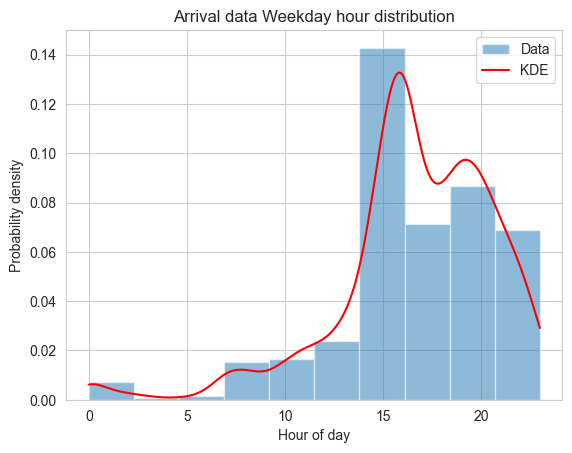

In [9]:
data_Weekday_hour = data_Weekday_plugin.dt.hour # convert time values to hours data for fitting
kde_data_Weekday_hour = gaussian_kde(data_Weekday_hour) # use kde function to find data distribution function
x = np.linspace(data_Weekday_hour.min(), data_Weekday_hour.max(), data_Weekday_hour.shape[0])
pdf_data_Weekday_hour = kde_data_Weekday_hour(x)
plt.hist(data_Weekday_hour, bins=10, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf_data_Weekday_hour, 'r', label='KDE')
plt.title('Arrival data Weekday hour distribution')
plt.xlabel('Hour of day')
plt.ylabel('Probability density')
plt.legend()
plt.show()

### Arrival Weekend

*   KDE estimator used to find arrival distribution -> arrival assumed to be the same as plugin time


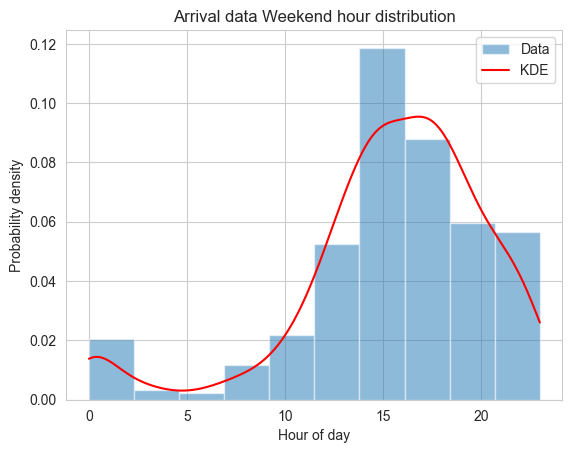

In [230]:
data_Weekend_hour = data_Weekend_plugin.dt.hour  # convert time values to hours data for fitting
kde_data_Weekend_hour = gaussian_kde(data_Weekend_hour)  # use kde function to find data distribution function
x = np.linspace(data_Weekend_hour.min(), data_Weekend_hour.max(), data_Weekend_hour.shape[0])
pdf_data_Weekend_hour = kde_data_Weekend_hour(x)

plt.hist(data_Weekend_hour, bins=10, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf_data_Weekend_hour, 'r', label='KDE')

plt.title('Arrival data Weekend hour distribution')
plt.xlabel('Hour of day')
plt.ylabel('Probability density')
plt.legend()
plt.show()

### Wait time until departure


*    KDE estimator used to find best distributon for wait time for week days and weekends



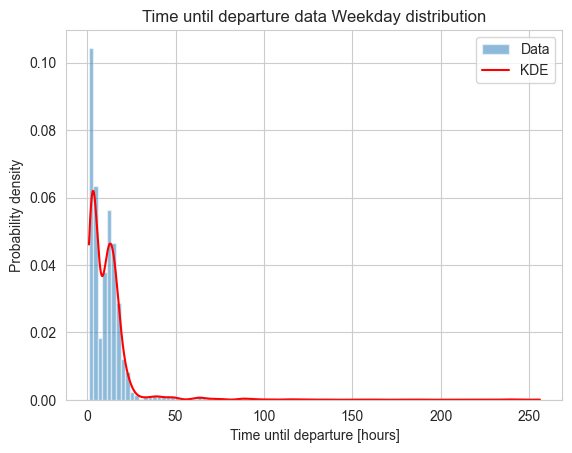

In [231]:
kde_time_delta_weekday = gaussian_kde(time_delta_weekday)
x = np.linspace(time_delta_weekday.min(), time_delta_weekday.max(), time_delta_weekday.shape[0])
pdf_time_delta_weekday = kde_time_delta_weekday(x)
plt.hist(time_delta_weekday, bins=100, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf_time_delta_weekday, 'r', label='KDE')
plt.title('Time until departure data Weekday distribution')
plt.xlabel('Time until departure [hours]')
plt.ylabel('Probability density')
plt.legend()
plt.show()

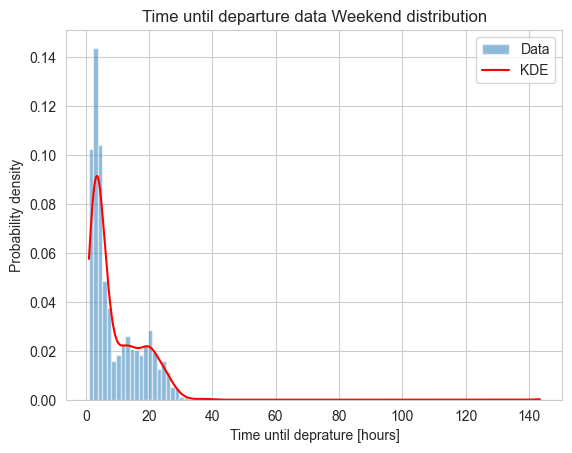

In [232]:
kde_time_delta_weekend = gaussian_kde(time_delta_weekend)
x = np.linspace(time_delta_weekend.min(), time_delta_weekend.max(), time_delta_weekend.shape[0])
pdf_time_delta_weekend = kde_time_delta_weekend(x)
plt.hist(time_delta_weekend, bins=100, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf_time_delta_weekend, 'r', label='KDE')
plt.title('Time until departure data Weekend distribution')
plt.xlabel('Time until deprature [hours]')
plt.ylabel('Probability density')
plt.legend()
plt.show()

### 1.4.	Estimated Driving Distance (EDD)


In [233]:
mu = 51; sigma = 11
EDD_dist = pd.Series(np.random.normal(mu, sigma, N_ev))

### 1.5.	Energy Needed on next Departure ENonD:

In [234]:
#Energy Needed on next Departure (ENonD):
def calc_ENonD(EDD_dist,EV_efficancy):
  ENunD = (EDD_dist * EV_efficancy) /1000 # convert to KW
  return pd.Series(ENunD)


In [235]:
# user data to export
df_user = pd.DataFrame(columns=['UID', 'Arrival_time', 'Departure_time', 'Estimated_Drive_Distance'])

In [236]:

def get_data_from_kde(kde_obj, N_samples):
    """function to sample data from KDE distributions"""
    arr = (kde_obj.resample(N_samples))
    arr = pd.Series(np.reshape(arr, arr.shape[1]))
    arr = arr.where(arr < 23.99, 23.99) # limit hour of day or wait time to 23.99 hour_of_day / hours
    arr = arr.where(arr >= 1, 1.5) # to prevent zero time between arrival to departure 1.5 hours added
    return arr

def get_departure_time(arrival_times,delta_times):
  """function to Convert float hour values to real hour values (int) and create DateTime objects"""
  datetime_objects = []
  time_now = datetime.now()
  for hour in arrival_times:
    hour, minute = divmod(hour * 60, 60)
    datetime_obj = time_now.replace(hour=int(hour), minute=int(minute))
    datetime_objects.append(datetime_obj)

  # Format the DateTime objects as "dd/mm/yy - hh:mm"
  formatted_dates = pd.Series([datetime_obj.strftime("%d/%m/%y - %H:%M") for datetime_obj in datetime_objects])
  formatted_dates = pd.to_datetime(formatted_dates)
  timedelta_series = pd.to_timedelta(delta_times, unit='h')
  departure_times =(formatted_dates + timedelta_series)
  return departure_times

def convert_float_time_to_datetime(float_time):
      # Convert float hour values to real hour values and create DateTime objects
  datetime_objects = []
  time_now = datetime.now()
  for hour in float_time:
    hour, minute = divmod(hour * 60, 60)
    datetime_obj = time_now.replace(hour=int(hour), minute=int(minute))
    datetime_objects.append(datetime_obj)

  # Format the DateTime objects as "dd/mm/yy - hh:mm"
  formatted_dates = pd.Series([datetime_obj.strftime("%d/%m/%y - %H:%M") for datetime_obj in datetime_objects])
  formatted_dates = pd.to_datetime(formatted_dates)
  return formatted_dates


In [237]:
# TODO: document that only week days data exported
#Users_ID
# Get arrival and departure data to generate Users dataset
weekday_arrival = get_data_from_kde(kde_data_Weekday_hour, N_ev)
weekday_departure = get_departure_time(weekday_arrival, get_data_from_kde(kde_time_delta_weekday, N_ev))
weekday_arrival = convert_float_time_to_datetime(weekday_arrival)

df_user['UID'] = Users_ID
df_user['Arrival_time'] = weekday_arrival
df_user['Departure_time'] = weekday_departure
df_user['Estimated_Drive_Distance'] = EDD_dist
df_user['TuD (int)'] =((df_user['Departure_time'] - df_user['Arrival_time']).dt.total_seconds() / 3600)# / pd.Timedelta(minutes=1))/60

C:\Users\dtubiana\AppData\Local\Temp\ipykernel_7564\3710815776.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  formatted_dates = pd.to_datetime(formatted_dates)
C:\Users\dtubiana\AppData\Local\Temp\ipykernel_7564\3710815776.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  formatted_dates = pd.to_datetime(formatted_dates)


### check data validity

Text(0.5, 0, 'Time of day (hour)')

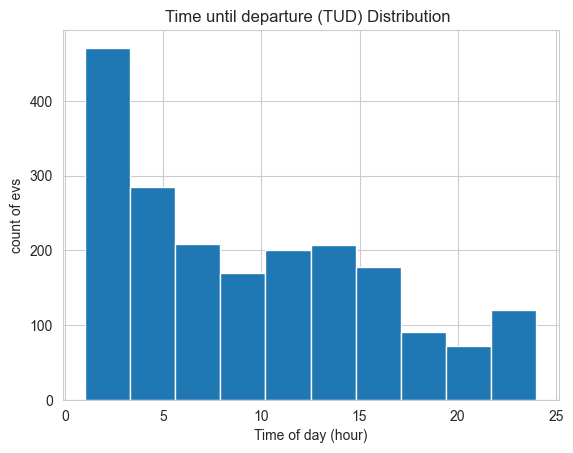

In [238]:
#df_user['time_delta'] = ((df_user['Departure_time'] - df_user['Arrival_time']).dt.total_seconds()/3600)
# time until departure distribution
plt.hist(df_user['TuD (int)'])
plt.title('Time until departure (TUD) Distribution ')
plt.ylabel('count of evs')
plt.xlabel('Time of day (hour)')

C:\Users\dtubiana\AppData\Local\Temp\ipykernel_7564\2612835508.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


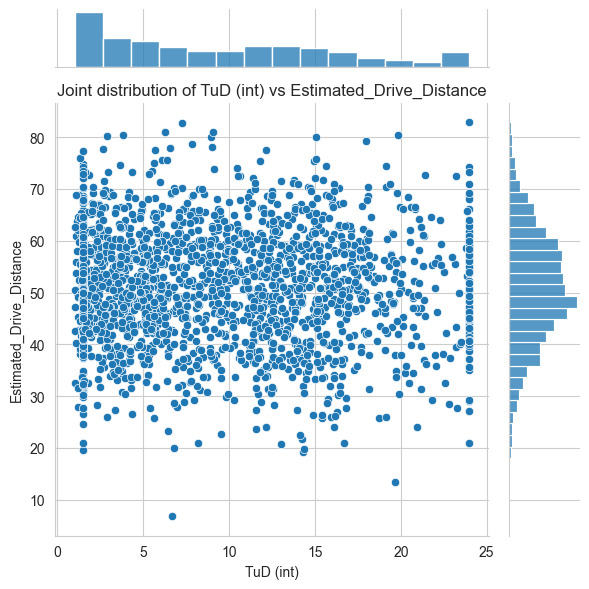

In [239]:
# Time until departure vs Estimated_Drive_Distance
sns.jointplot(data=df_user , x ='TuD (int)' , y= 'Estimated_Drive_Distance')
plt.title('Joint distribution of TuD (int) vs Estimated_Drive_Distance')
plt.tight_layout()

Text(0.5, 0, 'charge time [h]')

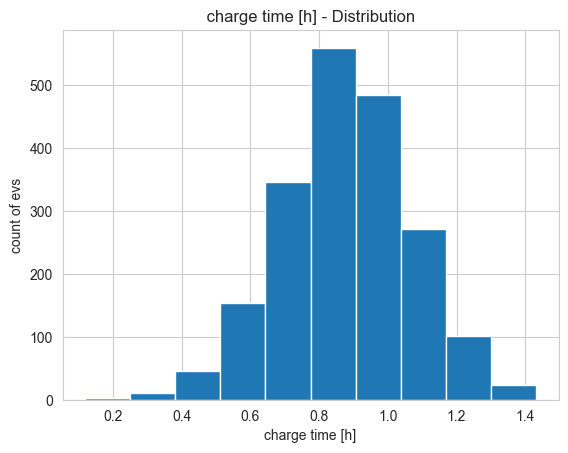

In [240]:
# charge time distribution : based on maximal ev efficiency which consumes maximal energy per km
plt.hist(((df_user['Estimated_Drive_Distance']*190)/1000)/11) #EFFICANCY -190; charge rate 11

plt.title(' charge time [h] - Distribution ')
plt.ylabel('count of evs')
plt.xlabel('charge time [h]')

C:\Users\dtubiana\AppData\Local\Temp\ipykernel_7564\127215191.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


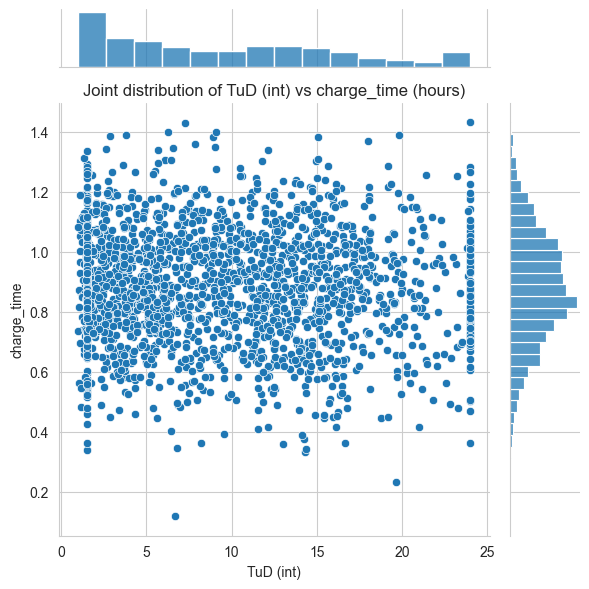

In [241]:
# charge time distribution vs time until departure: based on maximal ev efficiency which consumes maximal energy per km
df_user['charge_time'] = ((df_user['Estimated_Drive_Distance']*190)/1000)/11

sns.jointplot(data=df_user , x ='TuD (int)' , y= 'charge_time')
plt.title('Joint distribution of TuD (int) vs charge_time (hours)')
plt.tight_layout()

In [242]:
# find if there are cases that charge time is larger than time delta -> those cases are not allowed since the algo could  not solve this problem
(df_user['charge_time'] > df_user['TuD (int)']).sum()

2

In [244]:
# Keep all cases that time until departure(TUD) is larger than charge time
#-> cases that charge time is larger than TUD are not allowed even max charge rate and prioritization could not solve those cases
df_user = df_user[df_user['charge_time'] - df_user['TuD (int)'] < 0]
# check shape of dataframe
df_user.shape

(1998, 6)

# EVS data generation
load the 8 best-selling cars in Israel

In [245]:
df_ev = pd.read_excel('EVs_isr_data.xlsx')

In [246]:
df_ev

,Brand_Model,Range [Km],Efficiency [Wh/Km],Battery capacity [KWh],Max charge rate AC [Kw],Prob_to_buy,amount
0,Geely Geometry C,460,152,70.0,11,0.317555,6816
1,Tesla Model 3,405,142,57.5,11,0.216549,4648
2,BYD Atto 3,325,186,60.5,11,0.172568,3704
3,Hyundai Ioniq 5,295,183,54.0,11,0.083116,1784
4,aiways u5,315,190,60.0,11,0.061126,1312
5,skoda enyaq,435,177,77.0,11,0.058796,1262
6,Tesla Model Y,350,164,57.5,11,0.051295,1101
7,Hyundai Kona,394,162,64.0,11,0.038996,837


In [247]:
df_ev_sampled = df_ev.sample(n=N_ev, replace=True, weights=df_ev['Prob_to_buy']).reset_index(drop=True)
# drop non-relevant columns [Prob_to_buy, amount]
df_ev_sampled = df_ev_sampled.drop(columns=['Prob_to_buy', 'amount', 'Max charge rate AC [Kw]'])

In [248]:
EV_ID = Users_ID
df_ev_sampled = pd.concat([EV_ID,df_ev_sampled],axis=1) # set the same ID of users to evs to merge the datasets
df_ev_sampled  = df_ev_sampled.rename(columns={0: 'EV_Id'})
df_ev_sampled['SOC'] = np.random.uniform(0.15, 0.5, len(df_ev_sampled)) # create soc based on uniform distribution
df_ev_sampled['ENonD'] = calc_ENonD(EDD_dist,df_ev_sampled['Efficiency [Wh/Km]']) # calculate energy needed on next departure based on ev efficacy

In [249]:
# show the first samples to evaluate dataframe
df_ev_sampled.head(10)

,EV_Id,Brand_Model,Range [Km],Efficiency [Wh/Km],Battery capacity [KWh],SOC,ENonD
0,0,Geely Geometry C,460,152,70.0,0.204949,5.734169
1,1,Geely Geometry C,460,152,70.0,0.218976,5.138693
2,2,BYD Atto 3,325,186,60.5,0.341296,11.541340
3,3,Geely Geometry C,460,152,70.0,0.158722,7.992416
4,4,aiways u5,315,190,60.0,0.246276,11.173159
5,5,Geely Geometry C,460,152,70.0,0.339256,10.090829
6,6,Tesla Model Y,350,164,57.5,0.467190,5.174246
7,7,Hyundai Ioniq 5,295,183,54.0,0.324814,10.237343
8,8,Geely Geometry C,460,152,70.0,0.286701,8.566294
9,9,Geely Geometry C,460,152,70.0,0.404873,6.526362


In [250]:
# merge users data and evs data to one dataframe
usr_ev_data = pd.merge(df_user, df_ev_sampled, left_on='UID', right_on='EV_Id')

In [251]:
usr_ev_data.head(10)

,UID,Arrival_time,Departure_time,Estimated_Drive_Distance,TuD (int),charge_time,EV_Id,Brand_Model,Range [Km],Efficiency [Wh/Km],Battery capacity [KWh],SOC,ENonD
0,0,2023-07-28 09:24:00,2023-07-28 23:27:38.111633582,37.724793,14.060587,0.651610,0,Geely Geometry C,460,152,70.0,0.204949,5.734169
1,1,2023-07-28 15:07:00,2023-07-29 07:39:57.176895134,33.807188,16.549216,0.583942,1,Geely Geometry C,460,152,70.0,0.218976,5.138693
2,2,2023-07-28 14:57:00,2023-07-29 08:01:40.636712276,62.050216,17.077955,1.071776,2,BYD Atto 3,325,186,60.5,0.341296,11.541340
3,3,2023-07-28 16:54:00,2023-07-29 09:35:07.770140149,52.581686,16.685492,0.908229,3,Geely Geometry C,460,152,70.0,0.158722,7.992416
4,4,2023-07-28 16:09:00,2023-07-29 08:54:22.453264119,58.806098,16.756237,1.015742,4,aiways u5,315,190,60.0,0.246276,11.173159
5,5,2023-07-28 16:44:00,2023-07-28 23:10:29.510689182,66.387030,6.441531,1.146685,5,Geely Geometry C,460,152,70.0,0.339256,10.090829
6,6,2023-07-28 14:58:00,2023-07-28 19:16:34.561328738,31.550279,4.309600,0.544959,6,Tesla Model Y,350,164,57.5,0.467190,5.174246
7,7,2023-07-28 16:11:00,2023-07-29 04:49:36.889004072,55.941767,12.643580,0.966267,7,Hyundai Ioniq 5,295,183,54.0,0.324814,10.237343
8,8,2023-07-28 19:35:00,2023-07-29 05:33:10.266445513,56.357195,9.969518,0.973442,8,Geely Geometry C,460,152,70.0,0.286701,8.566294
9,9,2023-07-28 01:53:00,2023-07-28 07:14:33.775390252,42.936593,5.359382,0.741632,9,Geely Geometry C,460,152,70.0,0.404873,6.526362


# 2. Electricity price from grid Table:

In [252]:
#def electricity_price_grid_data(Month, hour_of_day):
hours = [i for i in range(0, 24)]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
data_table = [[15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 59.4, 59.4, 59.4, 59.4, 59.4, 15.8, 15.8 ],
            [15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 59.4, 59.4, 59.4, 59.4, 59.4, 15.8, 15.8 ],
            [15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 18.2, 18.2, 18.2, 18.2, 18.2, 15.2, 15.2 ],
            [15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 18.2, 18.2, 18.2, 18.2, 18.2, 15.2, 15.2 ],
            [15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 18.2, 18.2, 18.2, 18.2, 18.2, 15.2, 15.2 ],
            [18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 95.4, 95.4, 95.4, 95.4, 95.4, 95.4, 18.6 ],
            [18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 95.4, 95.4, 95.4, 95.4, 95.4, 95.4, 18.6 ],
            [18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 95.4, 95.4, 95.4, 95.4, 95.4, 95.4, 18.6 ],
            [18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 18.6, 95.4, 95.4, 95.4, 95.4, 95.4, 95.4, 18.6 ],
            [15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 18.2, 18.2, 18.2, 18.2, 18.2, 15.2, 15.2 ],
            [15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 18.2, 18.2, 18.2, 18.2, 18.2, 15.2, 15.2 ],
            [15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 59.4, 59.4, 59.4, 59.4, 59.4, 15.8, 15.8 ]
            ]

data_table = np.transpose(data_table)
df_electricity_price = pd.DataFrame(index=hours, columns=months, data=data_table)

# 3. Electricity price from PV table:

In [253]:
pv_id = 1
ele_price = 0.45
pv_price_data = {'PV_id': [pv_id], 'electricity_price' : [ele_price] }
pv_price = pd.DataFrame(data=pv_price_data)
pv_price

,PV_id,electricity_price
0,1,0.45


# 4. Building electricity meter

## 4.1 Solar power input

In [254]:
df_irradiation = pd.read_json('beit_dagan_irradiation.json')

In [255]:
# Convert date column to datetime object
df_irradiation['date'] =  pd.to_datetime(df_irradiation['date'])
# create hour column from data column
df_irradiation['hour'] = df_irradiation['date'].dt.hour
# Aggregate data by an hour and get mean radiation intensity for each hour
df_NIP_rad_hour = df_irradiation.groupby('hour').agg({'NIP': 'mean'})

In [256]:
def PV_power(hour_of_day):
  pv_area = 50 # [m^2]
  pv_effiency = 0.2 # [%]
  Performance_Ratio = 0.75 # [%]

  lower_hour = math.floor(hour_of_day)
  upper_hour = math.ceil(hour_of_day)
  rad_lower_hour = df_NIP_rad_hour.iloc[lower_hour]['NIP']
  rad_upper_hour = df_NIP_rad_hour.iloc[upper_hour]['NIP']
  x = [lower_hour,upper_hour]
  y = [rad_lower_hour, rad_upper_hour]
  rad_level = np.interp(hour_of_day, x, y)
  power = pv_area * pv_effiency * Performance_Ratio * rad_level
  return power


In [257]:
power_output = []
for i in range(0,24):
  power_output.append(PV_power(i))

df_power_output_pv = pd.DataFrame(data={'Hour_of_day': np.arange(0,24), "PV_pwr_output": np.array(power_output)})
df_power_output_pv

,Hour_of_day,PV_pwr_output
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,335.524194
7,7,1821.572581
8,8,3099.717742
9,9,3844.193548


## 4.2 Grid power Input

In [258]:
Max_power_allowed_transformer = 630 # [KVA]
power_factor_transformer = 0.56
Grid_max_power_input = Max_power_allowed_transformer * power_factor_transformer
power_input_grid = np.ones(24) * Grid_max_power_input
grid_pwr_data  = {"Hour_of_day" : np.arange(0,24), "PWR_input_grid[KW]": power_input_grid}
df_grid_pwr  = pd.DataFrame(data =grid_pwr_data)
df_grid_pwr

,Hour_of_day,PWR_input_grid[KW]
0,0,352.8
1,1,352.8
2,2,352.8
3,3,352.8
4,4,352.8
5,5,352.8
6,6,352.8
7,7,352.8
8,8,352.8
9,9,352.8


## 4.3 Household electricity load

In [259]:
df_houseload = pd.read_csv('household_power_consumption.csv')

In [260]:
df_houseload = df_houseload.dropna()
df_houseload['datetime'] = pd.to_datetime( df_houseload['datetime'])
df_houseload['hour'] = df_houseload['datetime'].dt.hour

df_houseload['Global_active_power[WH]'] = (df_houseload['Global_active_power']*1000 / 60) - (df_houseload['Sub_metering_1'] + df_houseload['Sub_metering_2'] + df_houseload['Sub_metering_3'])
df_houseload['Global_active_power[Kw]'] = df_houseload['Global_active_power[WH]']*60/1000

df_hour_grp = df_houseload.groupby('hour').agg({'Global_active_power[Kw]': 'mean'}).reset_index()

In [261]:
df_hour_grp['Global_active_power_N_households'] = df_hour_grp['Global_active_power[Kw]'] * n_households
hh_pwr_data  = {"Hour_of_day" : df_hour_grp['hour'], "PWR_consumption_out[KW]": df_hour_grp['Global_active_power_N_households']}
df_hh_pwr  = pd.DataFrame(data =hh_pwr_data)
df_hh_pwr

,Hour_of_day,PWR_consumption_out[KW]
0,0,53.707366
1,1,45.283642
2,2,41.483125
3,3,40.102271
4,4,38.933916
5,5,38.360048
6,6,64.884634
7,7,101.948301
8,8,70.390092
9,9,53.659988


# Building data To export

Merge data from PV, household power, and grid power input

In [262]:
df_building = pd.merge(df_hh_pwr, df_grid_pwr, on='Hour_of_day').merge(df_power_output_pv, on='Hour_of_day')
df_building

,Hour_of_day,PWR_consumption_out[KW],PWR_input_grid[KW],PV_pwr_output
0,0,53.707366,352.8,0.000000
1,1,45.283642,352.8,0.000000
2,2,41.483125,352.8,0.000000
3,3,40.102271,352.8,0.000000
4,4,38.933916,352.8,0.000000
5,5,38.360048,352.8,0.000000
6,6,64.884634,352.8,335.524194
7,7,101.948301,352.8,1821.572581
8,8,70.390092,352.8,3099.717742
9,9,53.659988,352.8,3844.193548


# Data export:
1. users and evs dataset
2. Electricity price table
3. PV (solar panels) price tables
4. Building power data

In [264]:
# export users and evs data table
new_path = 'C:/Users/dtubiana/PycharmProjects/chargeSystem/simulated_data'
os.chdir(new_path)
usr_ev_data.to_excel('usr_ev_data.xlsx')
df_electricity_price.to_excel('electricity_price.xlsx')
pv_price.to_excel('pv_price.xlsx')
df_building.to_excel('Building_data.xlsx')